In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid", context="talk")

# Loaded the summary that I created in Neighborhood_data.ipynb
nbhd_summary = pd.read_csv("Neighborhood_Summary.csv")

nbhd_summary.head()


,NeighborhoodInfoNAME,total_incidents,population,n_beats,n_districts,incidents_per_1000
0,10th Street N.W./Page St,3152,1006.0,1,1,3.133201e+03
1,29 North,46504,488.0,1,1,9.529508e+04
2,5th Street,244,775.0,1,1,3.148387e+02
3,BRSC,2756,0.0,1,1,inf
4,BRSC Area,9154,700.0,1,1,1.307714e+04


In [7]:
nbhd_summary.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NeighborhoodInfoNAME  33 non-null     object 
 1   total_incidents       33 non-null     int64  
 2   population            33 non-null     float64
 3   n_beats               33 non-null     int64  
 4   n_districts           33 non-null     int64  
 5   incidents_per_1000    33 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.7+ KB


In [8]:
nbhd_summary.describe()


/opt/miniconda3/envs/eda312/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,total_incidents,population,n_beats,n_districts,incidents_per_1000
count,33.000000,33.000000,33.0,33.0,33.000000
mean,6885.333333,1344.121212,1.0,1.0,inf
std,11375.691217,1199.983301,0.0,0.0,NaN
min,127.000000,0.000000,1.0,1.0,88.215024
25%,884.000000,670.000000,1.0,1.0,723.540146
50%,2756.000000,1006.000000,1.0,1.0,2682.933790
75%,5973.000000,1454.000000,1.0,1.0,9806.185567
max,46504.000000,5081.000000,1.0,1.0,inf


## Clean Population and recompute incidents_per_1000

In [9]:
# Ensured population is numeric
nbhd_summary["population"] = pd.to_numeric(nbhd_summary["population"], errors="coerce")

# Removed neighborhoods with missing or zero / negative population
nbhd_summary = nbhd_summary[nbhd_summary["population"] > 0].copy()

# If incidents_per_1000 is missing or was not created for some reason, this will recompute it
if "incidents_per_1000" not in nbhd_summary.columns:
    nbhd_summary["incidents_per_1000"] = (
        nbhd_summary["total_incidents"] / nbhd_summary["population"] * 1000
    )

nbhd_summary[["NeighborhoodInfoNAME", "total_incidents", "population", "incidents_per_1000"]].head()


,NeighborhoodInfoNAME,total_incidents,population,incidents_per_1000
0,10th Street N.W./Page St,3152,1006.0,3133.200795
1,29 North,46504,488.0,95295.081967
2,5th Street,244,775.0,314.838710
4,BRSC Area,9154,700.0,13077.142857
5,Belmont,29415,4327.0,6798.012480


## Created Features for Clustering & Standardize

In [10]:
# Log population for more stable scaling
nbhd_summary["log_population"] = np.log(nbhd_summary["population"])

# Check for inf / NaN from the log transform
print("Inf in log_population:", np.isinf(nbhd_summary["log_population"]).sum())
print("NaN in log_population:", nbhd_summary["log_population"].isna().sum())


Inf in log_population: 0
NaN in log_population: 0


In [11]:
# Define features for clustering
feature_cols = ["incidents_per_1000", "total_incidents", "log_population"]

# Keep only rows with complete feature data
mask = nbhd_summary[feature_cols].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)
nbhd_for_cluster = nbhd_summary.loc[mask].copy()

X = nbhd_for_cluster[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-0.25649672, -0.34025201,  0.09771422],
       [ 1.38781859,  3.47879844, -0.49150597],
       [-0.30678081, -0.59642931, -0.1147654 ],
       [-0.0790809 ,  0.18848809, -0.19766642],
       [-0.19111063,  1.97336033,  1.28596798]])

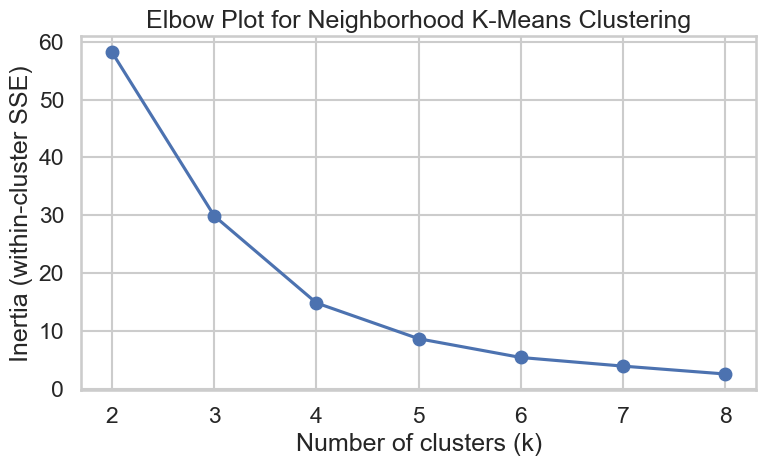

In [13]:
inertias = []

# To make sure we don't try more clusters than neighborhoods
max_k = min(8, len(nbhd_for_cluster) - 1)
K_values = range(2, max_k + 1)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_values, inertias, marker="o")
plt.xticks(list(K_values))
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Plot for Neighborhood K-Means Clustering")
plt.tight_layout()
plt.show()


In [14]:
# Choose k based on elbow plot; adjust if needed
k_opt = 3   # change to 4, etc., if your elbow suggests it

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the filtered neighborhood frame
nbhd_for_cluster["cluster"] = labels

# Initialize cluster column in the full table with NaN
nbhd_summary["cluster"] = np.nan

# Fill cluster labels only for rows we clustered
nbhd_summary.loc[nbhd_for_cluster.index, "cluster"] = nbhd_for_cluster["cluster"]

nbhd_summary[["NeighborhoodInfoNAME", "total_incidents", "population", "incidents_per_1000", "cluster"]].head()


,NeighborhoodInfoNAME,total_incidents,population,incidents_per_1000,cluster
0,10th Street N.W./Page St,3152,1006.0,3133.200795,1.0
1,29 North,46504,488.0,95295.081967,0.0
2,5th Street,244,775.0,314.838710,1.0
4,BRSC Area,9154,700.0,13077.142857,1.0
5,Belmont,29415,4327.0,6798.012480,0.0


In [15]:
cluster_profile = (
    nbhd_for_cluster
    .groupby("cluster")[["incidents_per_1000", "total_incidents", "population"]]
    .mean()
    .round(2)
)

cluster_profile


,incidents_per_1000,total_incidents,population
cluster,,,
0,34388.23,34260.00,2807.25
1,3997.20,2899.63,1225.85
2,314827.59,9130.00,29.00


In [16]:
nbhd_for_cluster["cluster"].value_counts().sort_index()


cluster
0     4
1    27
2     1
Name: count, dtype: int64

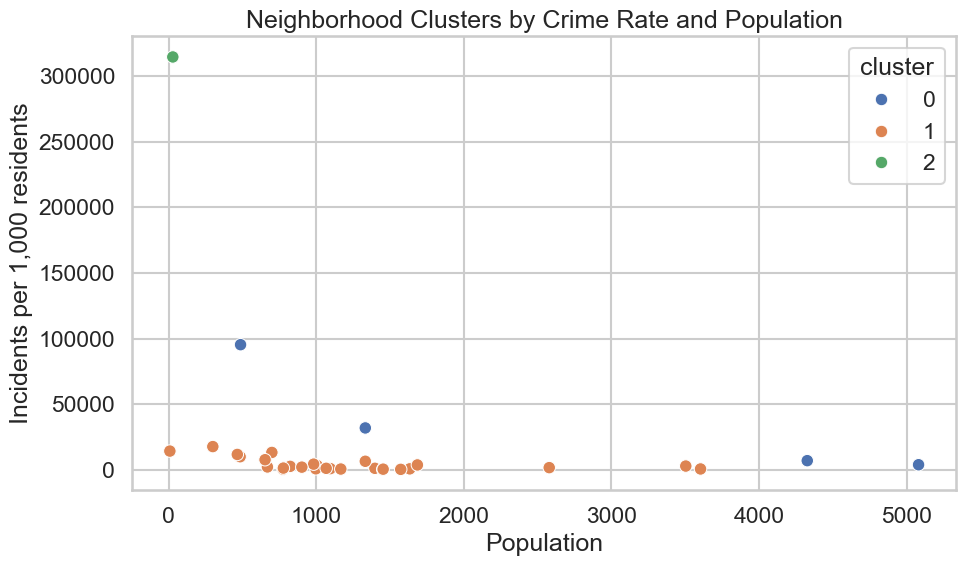

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=nbhd_for_cluster,
    x="population",
    y="incidents_per_1000",
    hue="cluster",
    palette="deep"
)
plt.title("Neighborhood Clusters by Crime Rate and Population")
plt.xlabel("Population")
plt.ylabel("Incidents per 1,000 residents")
plt.tight_layout()
plt.show()


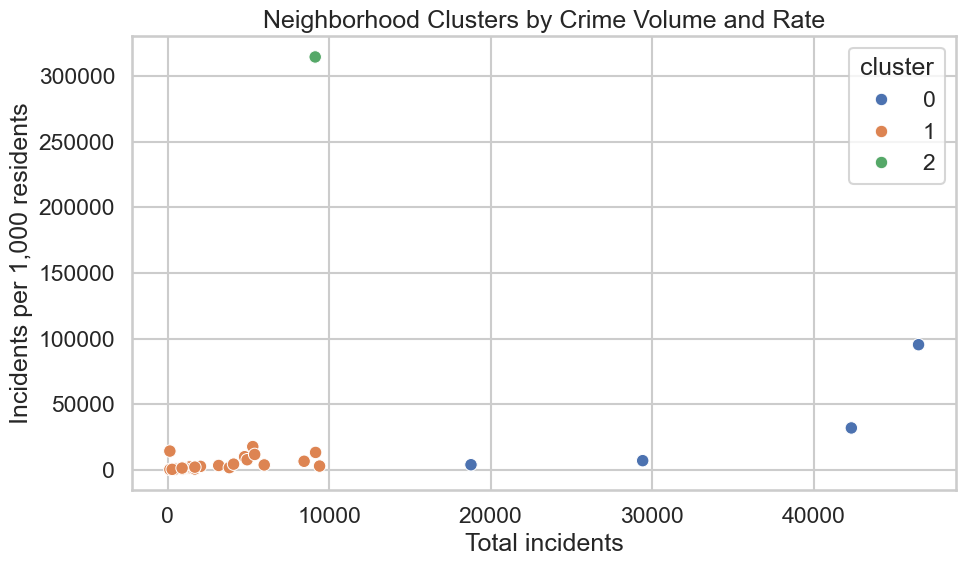

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=nbhd_for_cluster,
    x="total_incidents",
    y="incidents_per_1000",
    hue="cluster",
    palette="deep"
)
plt.title("Neighborhood Clusters by Crime Volume and Rate")
plt.xlabel("Total incidents")
plt.ylabel("Incidents per 1,000 residents")
plt.tight_layout()
plt.show()


In [19]:
nbhd_summary.to_csv("Neighborhood_Clusters.csv", index=False)
"Saved Neighborhood_Clusters.csv"


'Saved Neighborhood_Clusters.csv'

## This is just to show a few neighborhoods per cluster (prob wont need it, but just to have)

In [20]:
for c in sorted(nbhd_for_cluster["cluster"].unique()):
    print(f"\nCluster {c} example neighborhoods:")
    display(
        nbhd_for_cluster[nbhd_for_cluster["cluster"] == c]
        [["NeighborhoodInfoNAME", "total_incidents", "population", "incidents_per_1000"]]
        .sort_values("incidents_per_1000", ascending=False)
        .head(5)
    )



Cluster 0 example neighborhoods:


,NeighborhoodInfoNAME,total_incidents,population,incidents_per_1000
1,29 North,46504,488.0,95295.081967
30,West Main/Starr Hill,42341,1333.0,31763.690923
5,Belmont,29415,4327.0,6798.012480
29,Venable,18780,5081.0,3696.122810



Cluster 1 example neighborhoods:


,NeighborhoodInfoNAME,total_incidents,population,incidents_per_1000
8,Downtown,5262,300.0,17540.000000
27,The Corner,127,9.0,14111.111111
4,BRSC Area,9154,700.0,13077.142857
31,Westhaven,5381,466.0,11547.210300
11,Garrett,4756,485.0,9806.185567



Cluster 2 example neighborhoods:


,NeighborhoodInfoNAME,total_incidents,population,incidents_per_1000
20,Mall,9130,29.0,314827.586207
